<a href="https://colab.research.google.com/github/machiwao/CCTHESS1-CCTHESS2-Dev-and-Docs/blob/coli/ERA5_NDVI_NDBI_ALBEDO_Data%20Scraping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ERA5

In [ ]:
!pip install earthengine-api --upgrade
!pip install geemap --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 463.2/463.2 kB 3.4 MB/s eta 0:00:00
  Attempting uninstall: earthengine-api
    Found existing installation: earthengine-api 1.5.24
    Uninstalling earthengine-api-1.5.24:
      Successfully uninstalled earthengine-api-1.5.24
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 631.3/631.3 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 42.4 MB/s eta 0:00:00
  Attempting uninstall: geemap
    Found existing installation: geemap 0.35.3
    Uninstalling geemap-0.35.3:
      Successfully uninstalled geemap-0.35.3


In [ ]:
import ee, pandas as pd
import geemap

In [ ]:
ee.Authenticate()
ee.Initialize(project='data-scrapping-470316')

*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_7TDKVSyKvBdmMqW?ref=4i2o6


In [ ]:
# ERA5-Land Daily Aggregates dataset
dataset = ee.ImageCollection("ECMWF/ERA5_LAND/DAILY_AGGR") \
  .filterDate('2014-01-01', '2024-01-01')

In [ ]:
# Print available variables (bands)
bands = dataset.first().bandNames().getInfo()
print("Available Bands:", bands)
print("Dataset size:", dataset.size().getInfo())

Available Bands: ['dewpoint_temperature_2m', 'temperature_2m', 'skin_temperature', 'soil_temperature_level_1', 'soil_temperature_level_2', 'soil_temperature_level_3', 'soil_temperature_level_4', 'lake_bottom_temperature', 'lake_ice_depth', 'lake_ice_temperature', 'lake_mix_layer_depth', 'lake_mix_layer_temperature', 'lake_shape_factor', 'lake_total_layer_temperature', 'snow_albedo', 'snow_cover', 'snow_density', 'snow_depth', 'snow_depth_water_equivalent', 'snowfall_sum', 'snowmelt_sum', 'temperature_of_snow_layer', 'skin_reservoir_content', 'volumetric_soil_water_layer_1', 'volumetric_soil_water_layer_2', 'volumetric_soil_water_layer_3', 'volumetric_soil_water_layer_4', 'forecast_albedo', 'surface_latent_heat_flux_sum', 'surface_net_solar_radiation_sum', 'surface_net_thermal_radiation_sum', 'surface_sensible_heat_flux_sum', 'surface_solar_radiation_downwards_sum', 'surface_thermal_radiation_downwards_sum', 'evaporation_from_bare_soil_sum', 'evaporation_from_open_water_surfaces_excludi

In [ ]:
# FIXED: Corrected coordinates for baler, Philippines
baler = ee.Geometry.Point([121.970536,  20.427284]).buffer(25000)  # [longitude, latitude]
print("Geometry created:", baler.getInfo())

def extract(img):
    # Add error handling and debugging
    vals = img.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=baler,
        scale=11132,  # ERA5-Land native resolution is ~11km
        maxPixels=1e13,
        bestEffort=True  # Add this to handle large geometries
    )

    # Get the date
    date_val = img.date().format("YYYY-MM-dd")

    # Create feature with both values and date
    feature = ee.Feature(None, vals).set("date", date_val)
    return feature

# Apply extraction to all images
fc = dataset.map(extract)

Geometry created: {'type': 'Polygon', 'coordinates': [[[121.97053600000001, 20.65225564878704], [121.90338716124897, 20.643288882306127], [121.84160547459979, 20.617105362582638], [121.79012388896176, 20.575797413657597], [121.75304374153019, 20.522663786501155], [121.7333072757712, 20.461943726982682], [121.73246643854283, 20.39847646478299], [121.75056536522541, 20.337314189066134], [121.78614398290162, 20.283319870392138], [121.83636022252226, 20.24078192452345], [121.8972192856551, 20.21307582571173], [121.96389082629514, 20.20239868027073], [122.03108908508008, 20.209596890825473], [122.09348706550985, 20.23409985646023], [122.14613378328285, 20.27396466317643], [122.1848434366507, 20.326028426625697], [122.20652703578881, 20.386156859461035], [122.20944060624039, 20.44957025308714], [122.19332954187226, 20.511221888913735], [122.15945593935045, 20.566199412245833], [122.11050454097996, 20.61011735199697], [122.05037273533242, 20.63946909383302], [121.9838601156185, 20.65190938814

In [ ]:
# Debug: Check if feature collection is properly created
print("Feature collection size:", fc.size().getInfo())

# Get a sample to check if data extraction worked
sample = fc.limit(5).getInfo()
print("Sample features:", sample['features'][0]['properties'])

Feature collection size: 3652
Sample features: {'date': '2014-01-01'}


In [ ]:
# Extract dates and data
dates = fc.aggregate_array("date").getInfo()
print(f"Number of dates extracted: {len(dates)}")
print(f"First few dates: {dates[:5]}")

var_names = dataset.first().bandNames().getInfo()
print(f"Variable names: {var_names}")

Number of dates extracted: 3652
First few dates: ['2014-01-01', '2014-01-02', '2014-01-03', '2014-01-04', '2014-01-05']
Variable names: ['dewpoint_temperature_2m', 'temperature_2m', 'skin_temperature', 'soil_temperature_level_1', 'soil_temperature_level_2', 'soil_temperature_level_3', 'soil_temperature_level_4', 'lake_bottom_temperature', 'lake_ice_depth', 'lake_ice_temperature', 'lake_mix_layer_depth', 'lake_mix_layer_temperature', 'lake_shape_factor', 'lake_total_layer_temperature', 'snow_albedo', 'snow_cover', 'snow_density', 'snow_depth', 'snow_depth_water_equivalent', 'snowfall_sum', 'snowmelt_sum', 'temperature_of_snow_layer', 'skin_reservoir_content', 'volumetric_soil_water_layer_1', 'volumetric_soil_water_layer_2', 'volumetric_soil_water_layer_3', 'volumetric_soil_water_layer_4', 'forecast_albedo', 'surface_latent_heat_flux_sum', 'surface_net_solar_radiation_sum', 'surface_net_thermal_radiation_sum', 'surface_sensible_heat_flux_sum', 'surface_solar_radiation_downwards_sum', 'su

In [ ]:
# FIXED: Better error handling for data extraction
data = {}
for v in var_names:
    try:
        values = fc.aggregate_array(v).getInfo()
        data[v] = values
        print(f"Extracted {len([x for x in values if x is not None])} non-null values for {v}")
    except Exception as e:
        print(f"Error extracting {v}: {e}")
        data[v] = [None] * len(dates)

# Create DataFrame
df = pd.DataFrame({"date": dates})

Extracted 0 non-null values for dewpoint_temperature_2m
Extracted 0 non-null values for temperature_2m
Extracted 0 non-null values for skin_temperature
Extracted 0 non-null values for soil_temperature_level_1
Extracted 0 non-null values for soil_temperature_level_2
Extracted 0 non-null values for soil_temperature_level_3
Extracted 0 non-null values for soil_temperature_level_4
Extracted 0 non-null values for lake_bottom_temperature
Extracted 0 non-null values for lake_ice_depth
Extracted 0 non-null values for lake_ice_temperature
Extracted 0 non-null values for lake_mix_layer_depth
Extracted 0 non-null values for lake_mix_layer_temperature
Extracted 0 non-null values for lake_shape_factor
Extracted 0 non-null values for lake_total_layer_temperature
Extracted 0 non-null values for snow_albedo
Extracted 0 non-null values for snow_cover
Extracted 0 non-null values for snow_density
Extracted 0 non-null values for snow_depth
Extracted 0 non-null values for snow_depth_water_equivalent
Extrac

In [ ]:
# Add data columns with null checking
for v in var_names:
    if v in data:
        df[v] = data[v]
        null_count = df[v].isnull().sum()
        print(f"Column {v}: {len(df[v]) - null_count} valid values, {null_count} null values")

print("\nDataFrame shape:", df.shape)
print("DataFrame info:")
print(df.info())
print("\nFirst few rows:")
print(df.head())

ValueError: Length of values (0) does not match length of index (3652)

In [ ]:
# Unit conversions (only if data exists)
metadata = []
for col in df.columns:
    if col == "date":
        continue

    # Skip if all values are null
    if df[col].isnull().all():
        print(f"Skipping {col} - all values are null")
        continue

    original_name = col
    original_unit = "varies"
    converted_unit = original_unit
    new_name = col

    # Kelvin → Celsius
    if "temperature" in col.lower():
        df[col] = df[col] - 273.15
        new_name = col + "_C"
        original_unit, converted_unit = "K", "°C"
    # Precipitation / Runoff / Evaporation (m → mm/day)
    elif col.endswith("_sum") or "precipitation" in col.lower() or "evaporation" in col.lower() or "runoff" in col.lower():
        df[col] = df[col] * 1000
        new_name = col + "_mm"
        original_unit, converted_unit = "m", "mm/day"
    # Pressure (Pa → hPa)
    elif "pressure" in col.lower():
        df[col] = df[col] / 100
        new_name = col + "_hPa"
        original_unit, converted_unit = "Pa", "hPa"
    # Wind (m/s → km/h)
    elif "u_component" in col.lower() or "v_component" in col.lower() or "wind" in col.lower():
        df[col] = df[col] * 3.6
        new_name = col + "_kmh"
        original_unit, converted_unit = "m/s", "km/h"
    # Snow depth (m → cm)
    elif "snow_depth" in col.lower():
        df[col] = df[col] * 100
        new_name = col + "_cm"
        original_unit, converted_unit = "m", "cm"
    # Radiation & Fluxes (J/m²/day → W/m²)
    elif col.endswith("_radiation_sum") or col.endswith("_flux_sum") or col.endswith("_heat_sum"):
        df[col] = df[col] / 86400
        new_name = col + "_Wm2"
        original_unit, converted_unit = "J/m²/day", "W/m²"

    # Rename column
    if new_name != col:
        df.rename(columns={col: new_name}, inplace=True)

    # Add metadata record
    metadata.append({
        "Band": original_name,
        "Converted Column": new_name,
        "Original Unit": original_unit,
        "Converted Unit": converted_unit
    })

In [ ]:
# Build metadata DataFrame
meta_df = pd.DataFrame(metadata)
print("\nMetadata:")
print(meta_df)

In [ ]:
from google.colab import files

filename = "ERA5_Baler.csv"
df.to_csv(filename, index=False)

# --- Download ---
files.download(filename)


# NDVI

In [9]:
import ee
import geemap
import pandas as pd

In [10]:
cloud_project = 'data-scrapping-470316'

try:
  ee.Initialize(project=cloud_project)
except:
  ee.Authenticate()
  ee.Initialize(project=cloud_project)

stations = {
  "Basco": ee.Geometry.Point([121.970536, 20.427284]).buffer(25000),
  "Baler": ee.Geometry.Point([121.632028, 15.748809]).buffer(25000),
  "Ambulong": ee.Geometry.Point([121.0552444, 14.09008056]).buffer(25000),
  "Cabanatuan": ee.Geometry.Point([120.951143, 15.470387]).buffer(25000)
}
start_date = "2014-01-01"
end_date   = "2024-01-01"


In [11]:
def process_station(station_name, geometry, start_date, end_date):
    """
    Extract and process NDVI from VIIRS CDR dataset with scaling and interpolation.

    Dataset: NOAA/CDR/VIIRS/NDVI/V1
    Docs: https://developers.google.com/earth-engine/datasets/catalog/NOAA_CDR_VIIRS_NDVI_V1
    Scale factor: 0.0001
    Valid range: -1 to 1
    Native resolution: ~5566m
    """

    viirs_ndvi = ee.ImageCollection("NOAA/CDR/VIIRS/NDVI/V1").filterBounds(geometry).filterDate(start_date, end_date)

    print(f"Processing NDVI for {station_name}...")

    def extract_values(img):
        date = ee.Date(img.get('system:time_start')).format('YYYY-MM-dd')

        ndvi = img.select('NDVI').multiply(0.0001)  # apply scale factor
        ndvi = ndvi.updateMask(ndvi.gte(-1).And(ndvi.lte(1)))

        stats = ndvi.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=geometry,
            scale=5566,
            bestEffort=True,
            maxPixels=1e9
        )

        return ee.Feature(None, stats).set('date', date)

    # Map and convert
    features = viirs_ndvi.map(extract_values)
    df = geemap.ee_to_df(ee.FeatureCollection(features))

    if df.empty:
        print(f"No NDVI data for {station_name}")
        return df

    # Process timeseries
    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values("date").groupby("date").mean().reset_index()

    full_range = pd.date_range(start=start_date, end=end_date, freq="D")
    g = df.set_index("date").reindex(full_range).reset_index().rename(columns={"index": "date"})

    g["NDVI_original"] = g["NDVI"]
    g["NDVI_linear"] = g["NDVI"].interpolate("linear", limit_direction="both")
    g["NDVI_spline"] = g["NDVI"].interpolate("spline", order=2, limit_direction="both")

    out_file = f"{station_name}_NDVI.csv"
    g[["date", "NDVI_original", "NDVI_linear", "NDVI_spline"]].to_csv(out_file, index=False)

    print(f"Saved {out_file} ({g.shape[0]} rows)")
    return g

In [12]:
all_dfs = {}
for station, geom in stations.items():
    all_dfs[station] = process_station(station, geom, start_date, end_date)

Processing NDVI for Basco...
Saved Basco_NDVI.csv (3653 rows)
Processing NDVI for Baler...
Saved Baler_NDVI.csv (3653 rows)
Processing NDVI for Ambulong...
Saved Ambulong_NDVI.csv (3653 rows)
Processing NDVI for Cabanatuan...
Saved Cabanatuan_NDVI.csv (3653 rows)


In [13]:
# Check the first few rows of one of the dataframes
if all_dfs:
    first_station = list(all_dfs.keys())[0]
    print(f"First values for {first_station}:")
    display(all_dfs[first_station].head())
else:
    print("No dataframes were processed.")

First values for Basco:


,date,NDVI,NDVI_original,NDVI_linear,NDVI_spline
0,2014-01-01,0.59365,0.59365,0.59365,0.59365
1,2014-01-02,0.05486,0.05486,0.05486,0.05486
2,2014-01-03,0.54370,0.54370,0.54370,0.54370
3,2014-01-04,0.10806,0.10806,0.10806,0.10806
4,2014-01-05,0.46870,0.46870,0.46870,0.46870


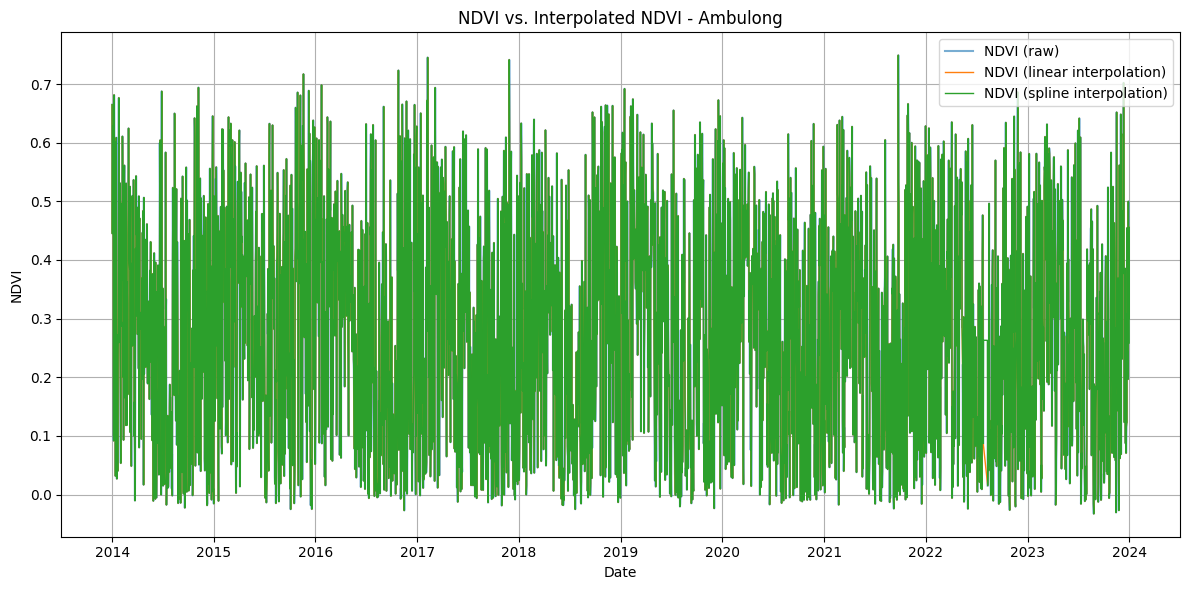

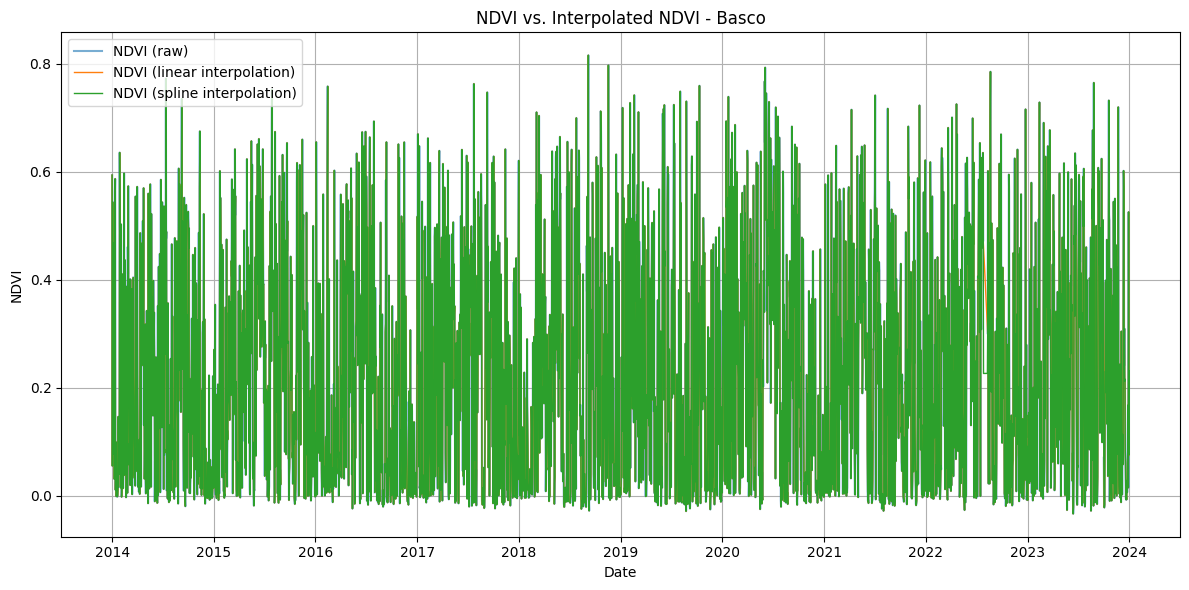

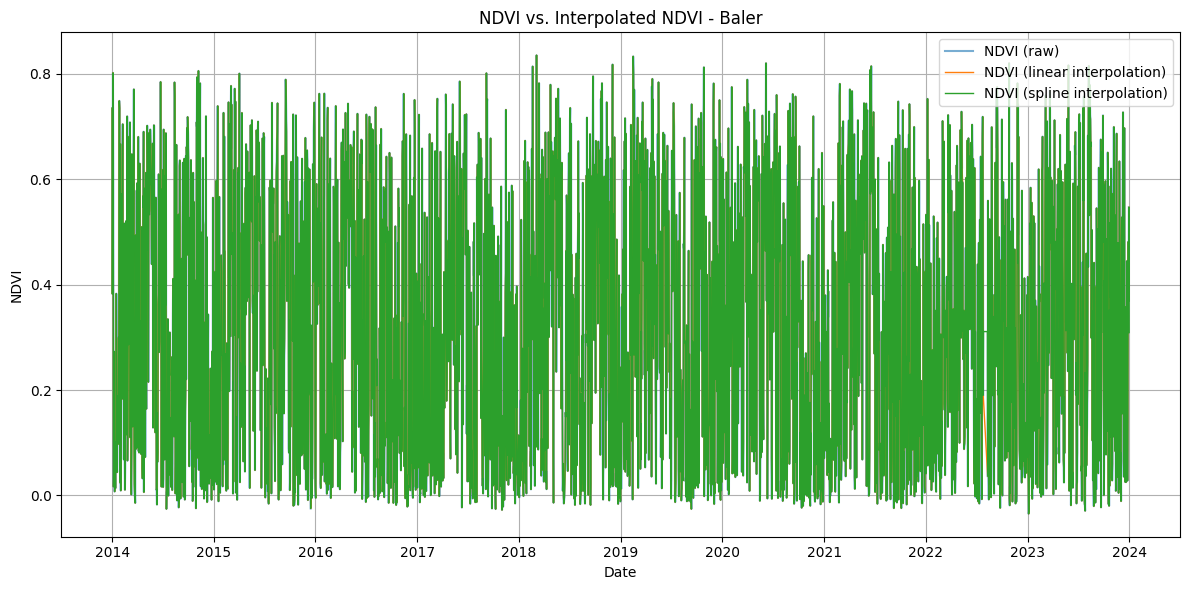

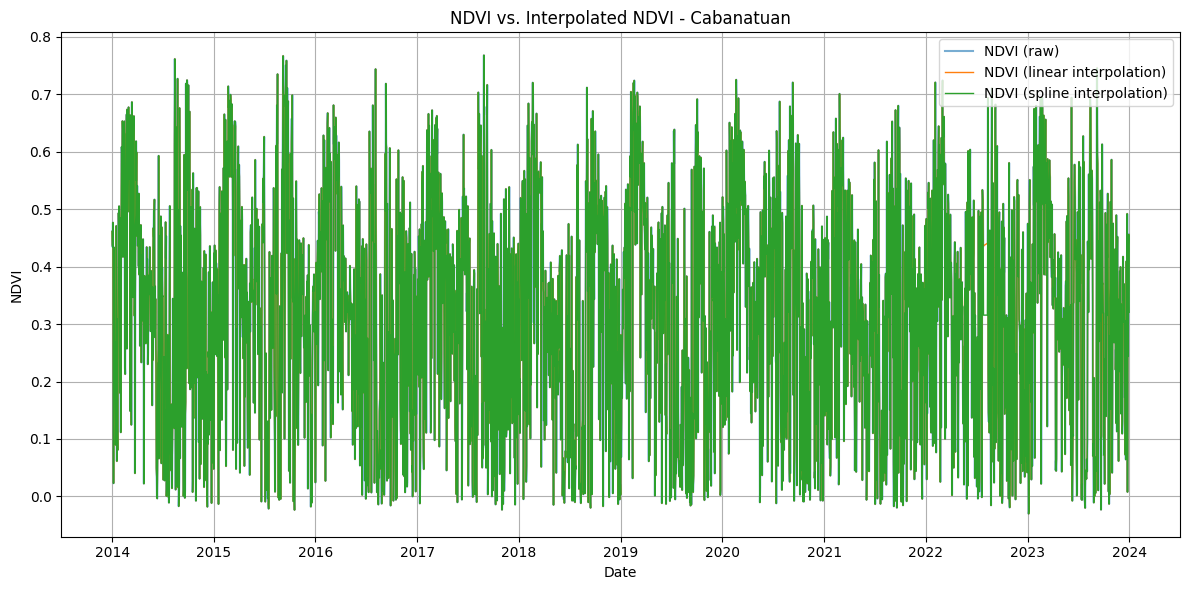

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_values(csv_file, station_name):
    # Load CSV (expects columns: date, NDVI_original, NDVI_linear, NDVI_spline)
    df = pd.read_csv(csv_file, parse_dates=["date"])

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(df["date"], df["NDVI_original"], label="NDVI (raw)", alpha=0.6)
    plt.plot(df["date"], df["NDVI_linear"], label="NDVI (linear interpolation)", linewidth=1)
    plt.plot(df["date"], df["NDVI_spline"], label="NDVI (spline interpolation)", linewidth=1)


    plt.xlabel("Date")
    plt.ylabel("NDVI")
    plt.title(f"NDVI vs. Interpolated NDVI - {station_name}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

station_names = ["Ambulong", "Basco", "Baler", "Cabanatuan"]
for station in station_names:
    csv_file = f"{station}_NDVI.csv"
    plot_values(csv_file, station)

# NDBI


In [1]:
import ee
import geemap
import pandas as pd
from scipy.signal import savgol_filter
import os

In [2]:
cloud_project = 'data-scrapping-470316'

try:
  ee.Initialize(project=cloud_project)
except:
  ee.Authenticate()
  ee.Initialize(project=cloud_project)

stations = {
  "Basco": ee.Geometry.Point([121.970536, 20.427284]).buffer(25000),
  "Baler": ee.Geometry.Point([121.632028, 15.748809]).buffer(25000),
  "Ambulong": ee.Geometry.Point([121.0552444, 14.09008056]).buffer(25000),
  "Cabanatuan": ee.Geometry.Point([120.951143, 15.470387]).buffer(25000)
}
start_date = "2014-01-01"
end_date   = "2024-01-01"



*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_7TDKVSyKvBdmMqW?ref=4i2o6


In [3]:
def get_hls_collection(region, start_date, end_date):
    # Landsat HLS
    hls_landsat = (
        ee.ImageCollection("NASA/HLS/HLSL30/v002")
        .filterBounds(region)
        .filterDate(start_date, end_date)
        .map(lambda img: img.select(["B5", "B6"])  # B05 = NIR, B06 = SWIR1
                         .multiply(0.0001)           # scale factor
                         .copyProperties(img, img.propertyNames()))
    )

    # Sentinel-2 HLS
    hls_sentinel = (
        ee.ImageCollection("NASA/HLS/HLSS30/v002")
        .filterBounds(region)
        .filterDate(start_date, end_date)
        .map(lambda img: img.select(["B8A", "B11"])  # B8A = NIR, B11 = SWIR1
                         .multiply(0.0001)
                         .rename(["B5", "B6"])     # rename to match Landsat
                         .copyProperties(img, img.propertyNames()))
    )

    # Merge both collections
    merged = hls_landsat.merge(hls_sentinel)

    # Compute NDBI = (SWIR - NIR) / (SWIR + NIR)
    def add_ndbi(img):
        ndbi = img.expression(
            "(SWIR - NIR) / (SWIR + NIR)",
            {"SWIR": img.select("B6"), "NIR": img.select("B5")}
        ).rename("NDBI")
        return img.addBands(ndbi).select("NDBI")

    return merged.map(add_ndbi)

In [4]:
def process_station(station_name, geometry, start_date, end_date):
    hls = get_hls_collection(geometry, start_date, end_date)

    print(f"Processing NDBI for {station_name}...")

    ts = hls.map(lambda img: ee.Feature(
        None, {
            "date": img.date().format("YYYY-MM-dd"),
            "NDBI": img.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=geometry,
                scale=30,
                bestEffort=True,
                maxPixels=1e9
            ).get("NDBI")
        }
    ))

    df = geemap.ee_to_df(ee.FeatureCollection(ts))

    if df.empty:
        print(f"No data for {station_name}")
        return df

    # Process time series
    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values("date").groupby("date").mean().reset_index()

    # Reindex to daily
    full_range = pd.date_range(start=start_date, end=end_date, freq="D")
    g = df.set_index("date").reindex(full_range)
    g.index.name = "date"
    g = g.reset_index()

    # Preserve original values
    g["NDBI_original"] = g["NDBI"]

    # Interpolate missing values only (keeping original intact)
    g["NDBI_linear"] = g["NDBI"].interpolate("linear", limit_direction="both")
    g["NDBI_spline"] = g["NDBI"].interpolate("spline", order=3, limit_direction="both")

    # Save to CSV: include original, interpolated, and smooth
    out_file = f"{station_name}_NDBI.csv"
    g[["date", "NDBI_original", "NDBI_linear", "NDBI_spline"]].to_csv(out_file, index=False)

    print(f"Saved {out_file} ({g.shape[0]} rows)")
    return g

In [5]:
all_dfs = {}
for station, geom in stations.items():
    all_dfs[station] = process_station(station, geom, start_date, end_date)

Processing NDBI for Basco...
Saved Basco_NDBI.csv (3653 rows)
Processing NDBI for Baler...
Saved Baler_NDBI.csv (3653 rows)
Processing NDBI for Ambulong...
Saved Ambulong_NDBI.csv (3653 rows)
Processing NDBI for Cabanatuan...
Saved Cabanatuan_NDBI.csv (3653 rows)


In [6]:
# Check the first few rows of one of the dataframes
if all_dfs:
    first_station = list(all_dfs.keys())[0]
    print(f"First values for {first_station}:")
    display(all_dfs[first_station].head())
else:
    print("No dataframes were processed.")

First values for Basco:


,date,NDBI,NDBI_original,NDBI_linear,NDBI_spline
0,2014-01-01,NaN,NaN,0.129255,0.736828
1,2014-01-02,NaN,NaN,0.129255,0.736405
2,2014-01-03,NaN,NaN,0.129255,0.735982
3,2014-01-04,NaN,NaN,0.129255,0.735560
4,2014-01-05,NaN,NaN,0.129255,0.735139


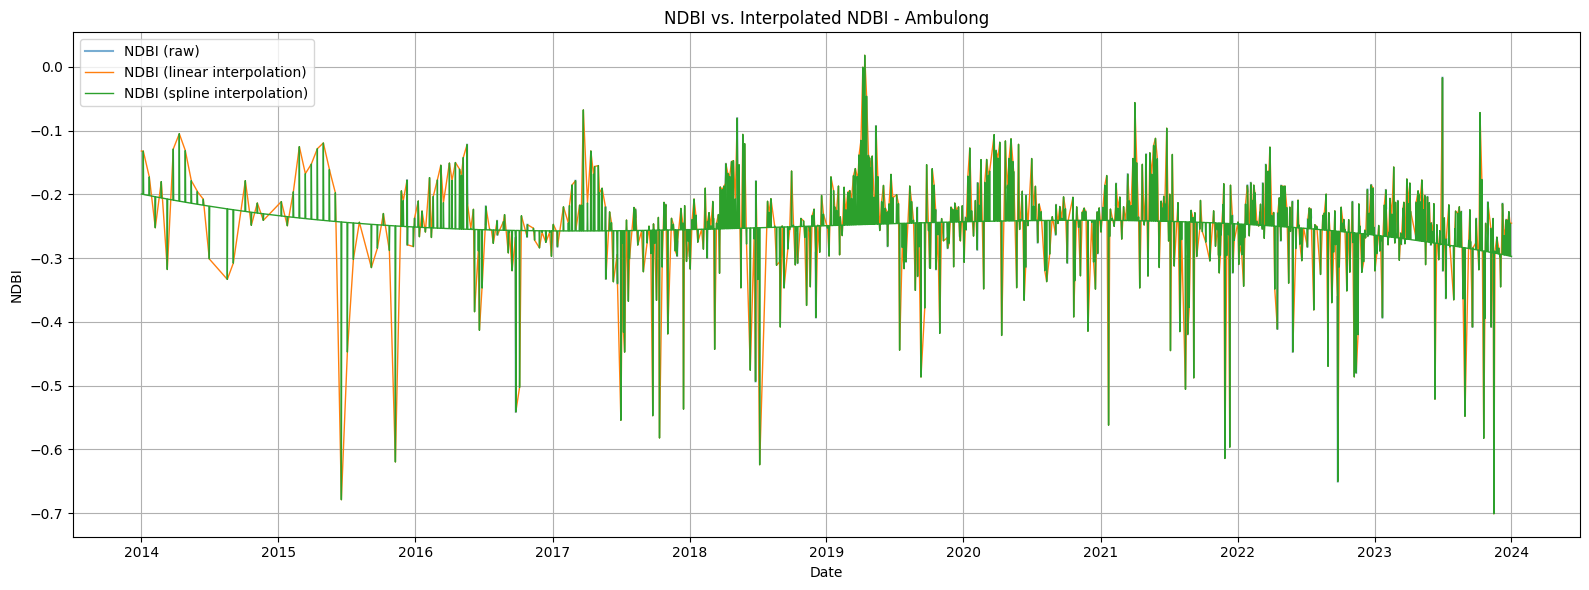

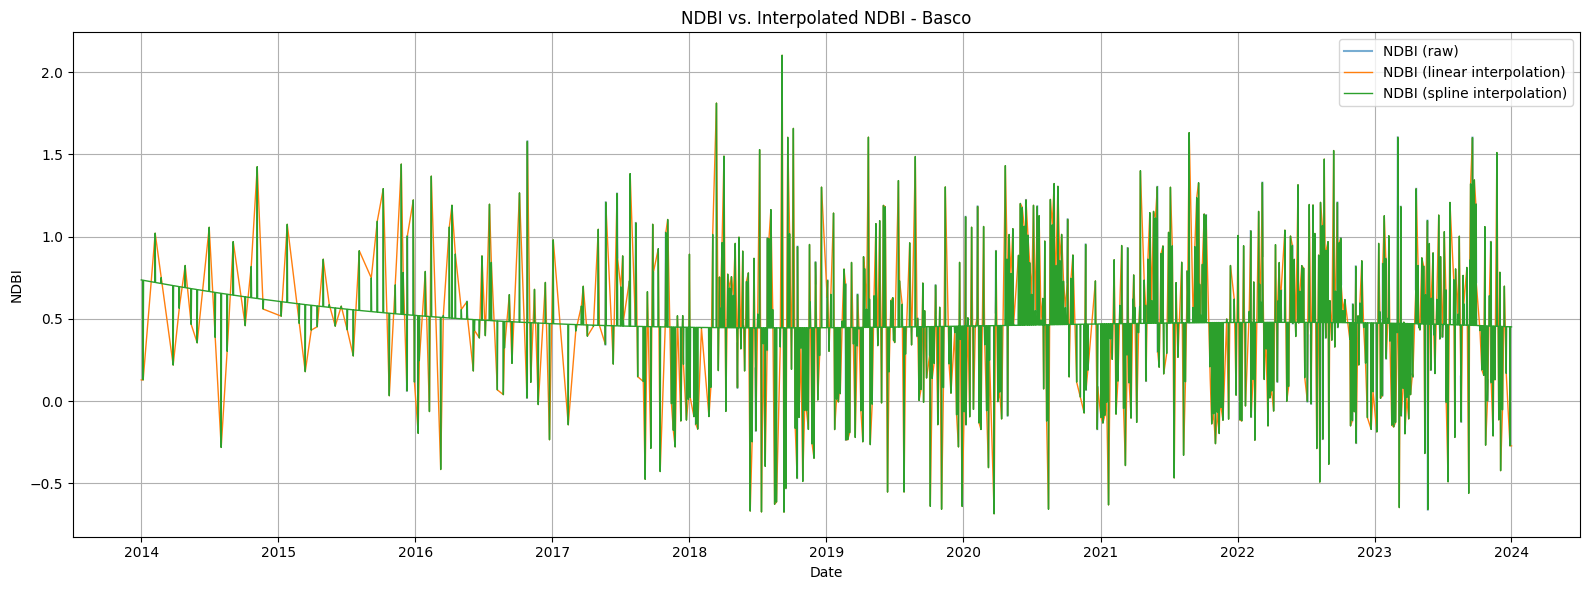

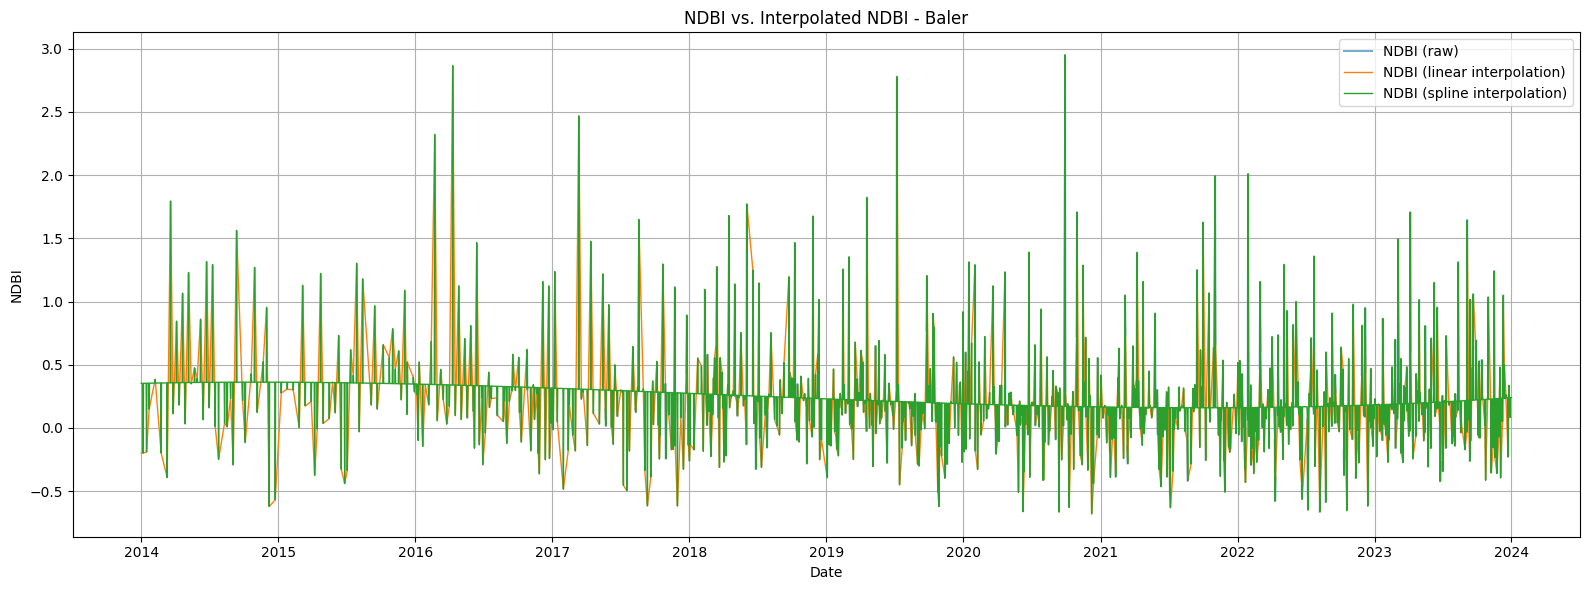

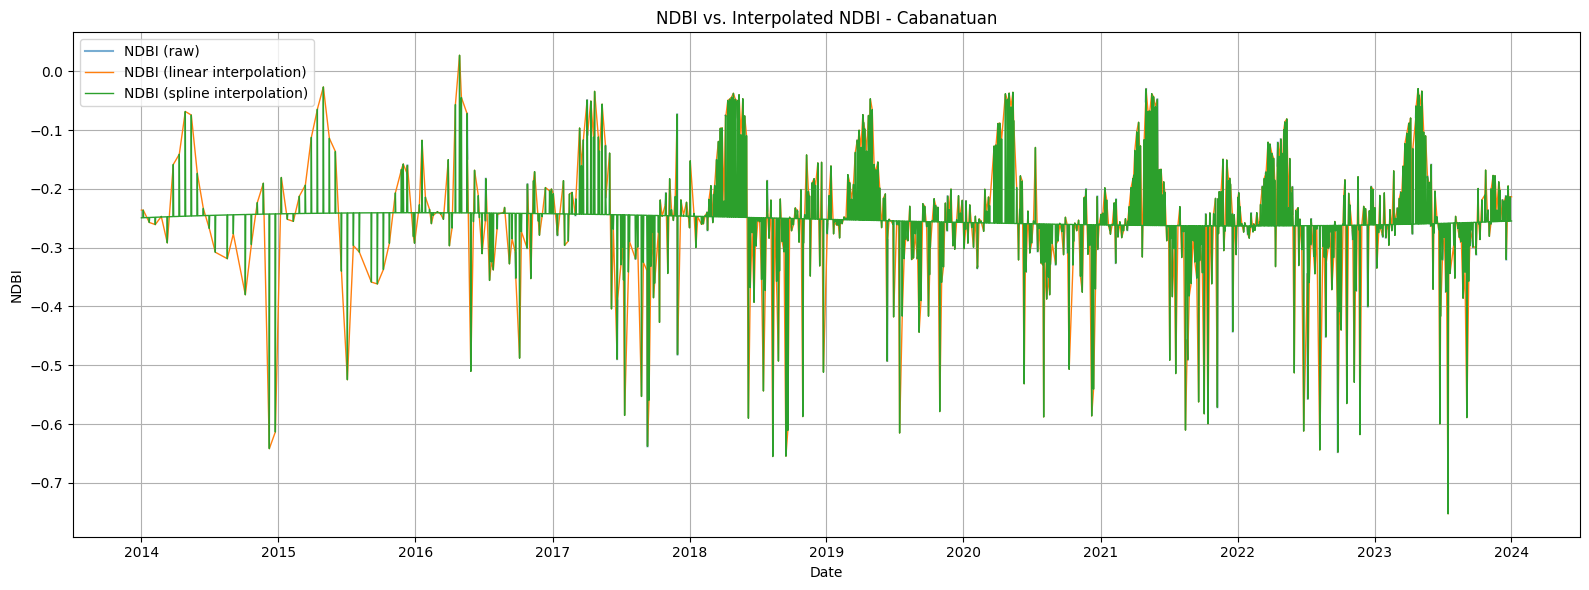

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_values(csv_file, station_name):
    # Load CSV (expects columns: date, NDBI_original, NDBI_linear, NDBI_spline)
    df = pd.read_csv(csv_file, parse_dates=["date"])

    # Plot
    plt.figure(figsize=(16, 6))
    plt.plot(df["date"], df["NDBI_original"], label="NDBI (raw)", alpha=0.6)
    plt.plot(df["date"], df["NDBI_linear"], label="NDBI (linear interpolation)", linewidth=1)
    plt.plot(df["date"], df["NDBI_spline"], label="NDBI (spline interpolation)", linewidth=1)


    plt.xlabel("Date")
    plt.ylabel("NDBI")
    plt.title(f"NDBI vs. Interpolated NDBI - {station_name}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

station_names = ["Ambulong", "Basco", "Baler", "Cabanatuan"]
for station in station_names:
    csv_file = f"{station}_NDBI.csv"
    plot_values(csv_file, station)

# Albedo


In [ ]:
!pip install earthengine-api geemap --upgrade

In [15]:
import ee
import geemap
import pandas as pd
from scipy.signal import savgol_filter

In [16]:
ee.Authenticate()
ee.Initialize(project='data-scrapping-470316')

In [17]:
# --- Define stations ---
stations = {
    "Basco": ee.Geometry.Point([121.970536, 20.427284]).buffer(25000),
    "Baler": ee.Geometry.Point([121.632028, 15.748809]).buffer(25000),
    "Ambulong": ee.Geometry.Point([121.0552444, 14.09008056]).buffer(25000),
    "Cabanatuan": ee.Geometry.Point([120.951143, 15.470387]).buffer(25000)
}

start_date = "2014-01-01"
end_date   = "2024-01-01"


In [18]:
def process_station(station_name, geometry, start_date, end_date):
    """
    Extract daily Albedo time series from HLS (HLSL30 for Landsat, HLSS30 for Sentinel).
    Applies interpolation and saves to CSV.
    """

    print(f"Processing Albedo for {station_name}...")

    # Landsat (HLSL30)
    hlsl = ee.ImageCollection("NASA/HLS/HLSL30/v002") \
        .filterDate(start_date, end_date) \
        .filterBounds(geometry)

    def landsat_albedo(img):
        date = img.date().format("YYYY-MM-dd")
        blue = img.select("B2")
        red = img.select("B4")
        nir = img.select("B5")
        swir1 = img.select("B6")
        swir2 = img.select("B7")

        albedo = (
            blue.multiply(0.356)
            .add(red.multiply(0.130))
            .add(nir.multiply(0.373))
            .add(swir1.multiply(0.085))
            .add(swir2.multiply(0.072))
            .subtract(0.0018)
        ).divide(1.016).rename("Albedo")

        return ee.Feature(
            None,
            {
                "date": date,
                "Albedo": albedo.reduceRegion(
                    reducer=ee.Reducer.mean(),
                    geometry=geometry,
                    bestEffort=True,
                    maxPixels=1e9,
                ).get("Albedo"),
            },
        )

    hlsl_features = hlsl.map(landsat_albedo)

    # Sentinel (HLSS30)
    hlss = ee.ImageCollection("NASA/HLS/HLSS30/v002") \
        .filterDate(start_date, end_date) \
        .filterBounds(geometry)

    def sentinel_albedo(img):
        date = img.date().format("YYYY-MM-dd")
        blue = img.select("B2")
        red = img.select("B4")
        nir = img.select("B8")
        swir1 = img.select("B11")
        swir2 = img.select("B12")

        albedo = (
            blue.multiply(0.356)
            .add(red.multiply(0.130))
            .add(nir.multiply(0.373))
            .add(swir1.multiply(0.085))
            .add(swir2.multiply(0.072))
            .subtract(0.0018)
        ).rename("Albedo")

        return ee.Feature(
            None,
            {
                "date": date,
                "Albedo": albedo.reduceRegion(
                    reducer=ee.Reducer.mean(),
                    geometry=geometry,
                    bestEffort=True,
                    maxPixels=1e9,
                ).get("Albedo"),
            },
        )

    hlss_features = hlss.map(sentinel_albedo)

    # Merge Landsat + Sentinel results
    features = hlsl_features.merge(hlss_features)

    # Convert to pandas
    df = geemap.ee_to_df(ee.FeatureCollection(features))

    if df.empty:
        print(f"No data for {station_name}")
        return None

    # Process time series
    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values("date").groupby("date").mean().reset_index()

    # Keep original values
    df = df.rename(columns={"Albedo": "Albedo_original"})

    # Reindex to daily frequency
    full_range = pd.date_range(start=start_date, end=end_date, freq="D")
    df = df.set_index("date").reindex(full_range)
    df.index.name = "date"
    df = df.reset_index()

    # Interpolation
    df["Albedo_linear"] = df["Albedo_original"].interpolate(method="linear", limit_direction="both")
    df["Albedo_spline"] = df["Albedo_original"].interpolate(method="spline", order=2, limit_direction="both")

    # Metadata
    df["station"] = station_name

    # Save
    filename = f"{station_name}_Albedo.csv"
    df.to_csv(filename, index=False)
    print(f"Saved {filename} with {df.shape[0]} rows")

    return df

In [19]:
all_dfs = {}
for station, geom in stations.items():
     all_dfs[station] = process_station(station, geom, start_date, end_date)

Processing Albedo for Basco...
Saved Basco_Albedo.csv with 3653 rows
Processing Albedo for Baler...
Saved Baler_Albedo.csv with 3653 rows
Processing Albedo for Ambulong...
Saved Ambulong_Albedo.csv with 3653 rows
Processing Albedo for Cabanatuan...
Saved Cabanatuan_Albedo.csv with 3653 rows


In [20]:
# Check the first few rows of one of the dataframes
if all_dfs:
    first_station = list(all_dfs.keys())[0]
    print(f"First values for {first_station}:")
    display(all_dfs[first_station].head())
else:
    print("No dataframes were processed.")

First values for Basco:


,date,Albedo_original,Albedo_linear,Albedo_spline,station
0,2014-01-01,NaN,0.445675,0.082537,Basco
1,2014-01-02,NaN,0.445675,0.082606,Basco
2,2014-01-03,NaN,0.445675,0.082675,Basco
3,2014-01-04,NaN,0.445675,0.082744,Basco
4,2014-01-05,NaN,0.445675,0.082813,Basco


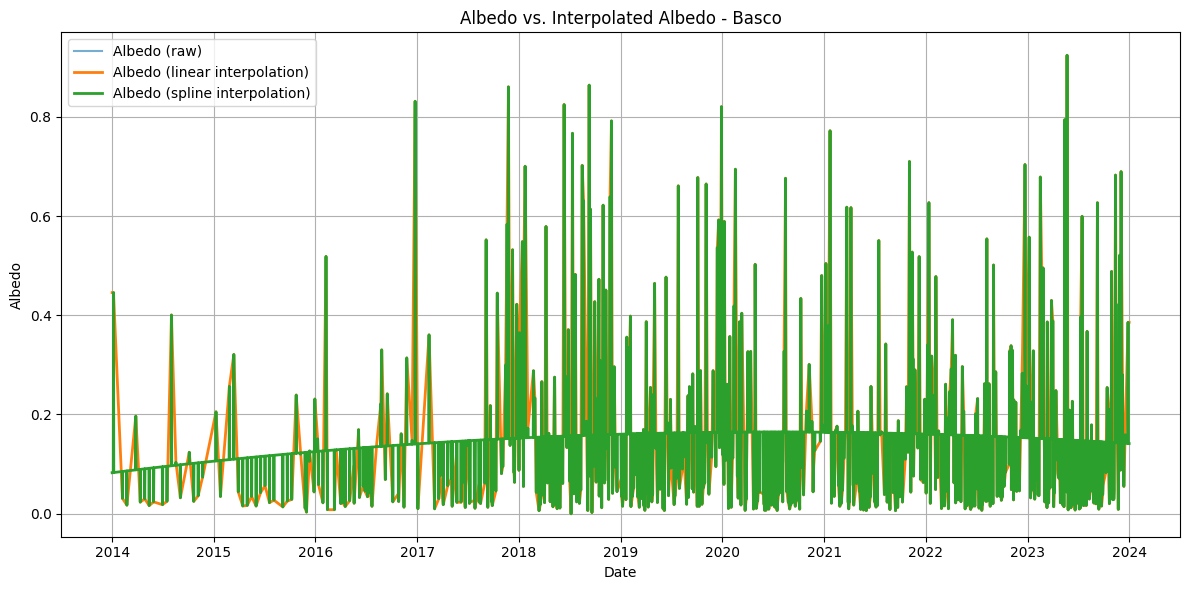

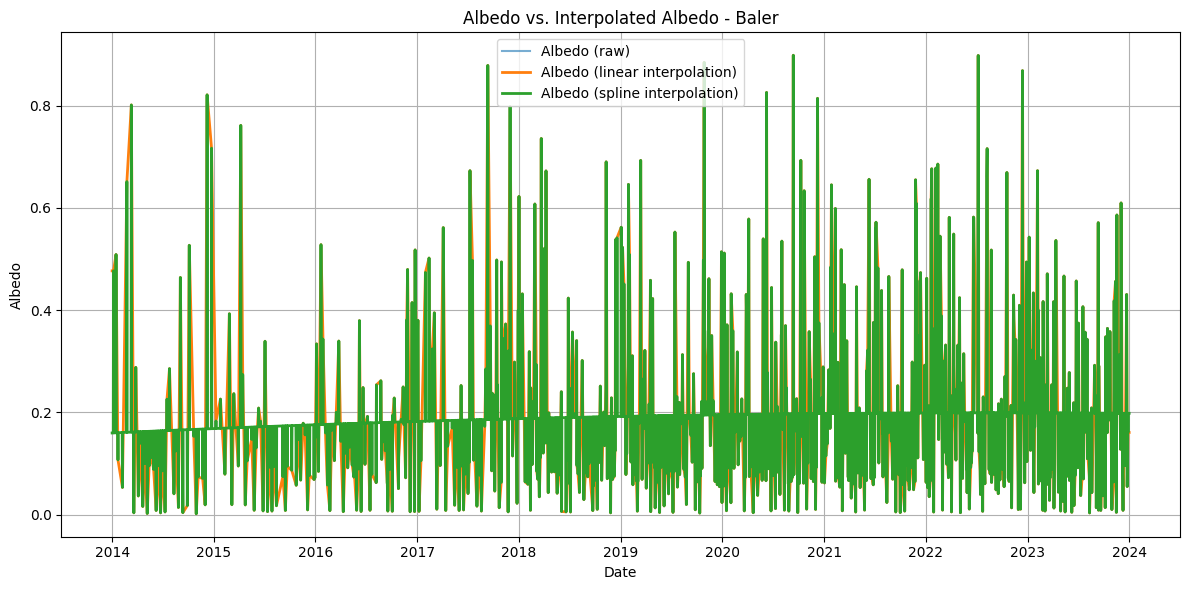

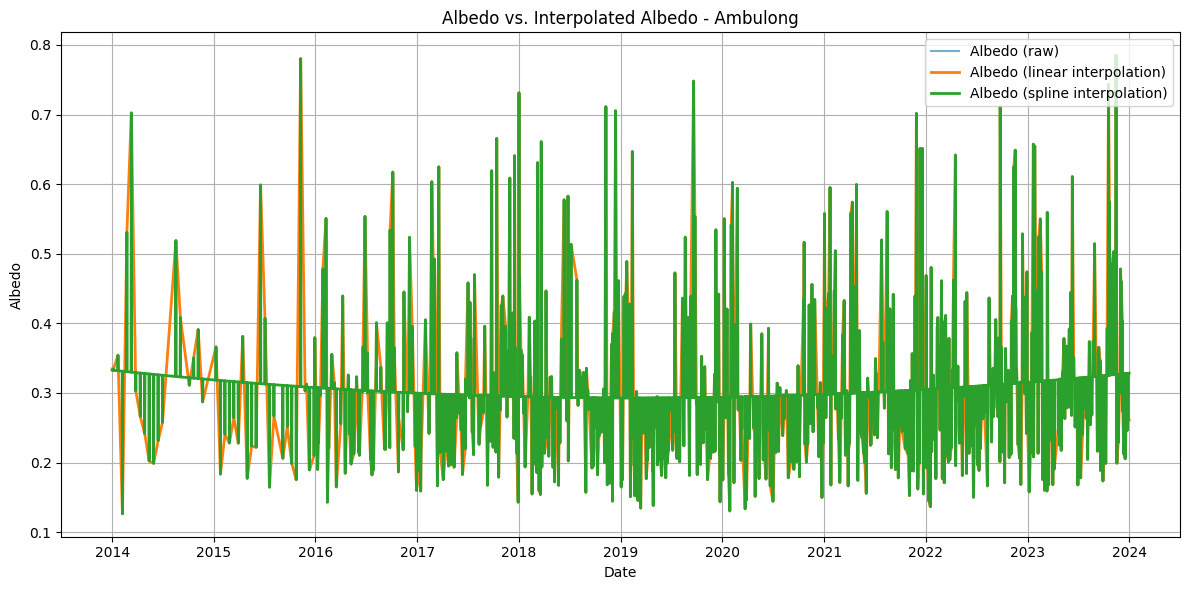

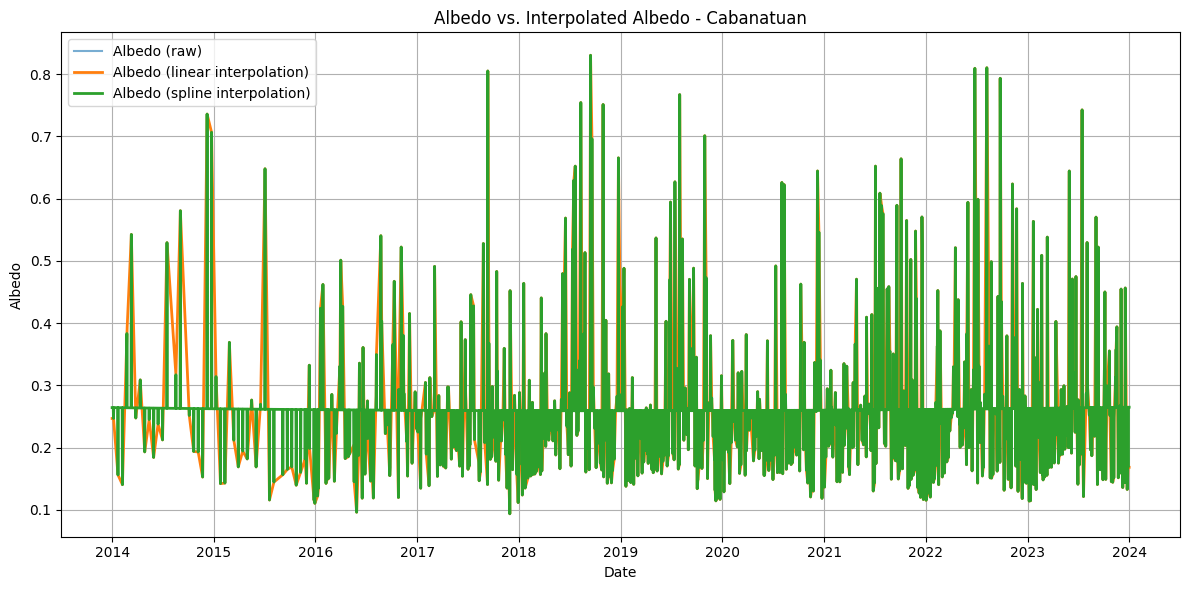

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_values(csv_file, station_name):
    # Load CSV (expects columns: date, NDBI_original, NDBI_linear, NDBI_spline)
    df = pd.read_csv(csv_file, parse_dates=["date"])

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(df["date"], df["Albedo_original"], label="Albedo (raw)", alpha=0.6)
    plt.plot(df["date"], df["Albedo_linear"], label="Albedo (linear interpolation)", linewidth=2)
    plt.plot(df["date"], df["Albedo_spline"], label="Albedo (spline interpolation)", linewidth=2)


    plt.xlabel("Date")
    plt.ylabel("Albedo")
    plt.title(f"Albedo vs. Interpolated Albedo - {station_name}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

station_names = ["Basco", "Baler", "Ambulong", "Cabanatuan"]
for station in station_names:
    csv_file = f"{station}_Albedo.csv"
    plot_values(csv_file, station)
